# 第7部　時系列予測の実践的技術

## 第1章　モデルの保存と読み込み

### 分析の準備

In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 状態空間モデルの推定と予測

In [3]:
# データの読み込み
train_sample = pd.read_csv('7-1-1-train-sample-1.csv', 
                      index_col='date', 
                      parse_dates=True, 
                      dtype='float')

# 日データであることの指定
train_sample.index.freq = 'D'

# 結果の確認
print(train_sample.head(2))
print(train_sample.tail(2))

                     y
date                  
2000-05-01  182.079325
2000-05-02  141.334794
                     y
date                  
2000-08-07  264.246774
2000-08-08  214.887515


In [4]:
# 季節変動ありのローカル線形トレンドモデル
mod_sample = tsa.UnobservedComponents(
    train_sample['y'],              # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    seasonal=7                      # 周期
).fit()

# 推定されたパラメータ
mod_sample.params

sigma2.irregular     0.106428
sigma2.level        23.394582
sigma2.trend         0.175057
sigma2.seasonal      0.092431
dtype: float64

In [5]:
# 予測
forecast_sample = mod_sample.forecast(7)

# 予測結果の確認
forecast_sample

2000-08-09    246.809538
2000-08-10    277.555325
2000-08-11    296.190844
2000-08-12    325.586665
2000-08-13    317.303417
2000-08-14    269.801246
2000-08-15    221.203045
Freq: D, Name: predicted_mean, dtype: float64

### 状態空間モデルの保存と読み込み

#### pickle化と読み込み

In [6]:
# モデルの保存
# 事前にmodフォルダを作っておくこと
mod_sample.save('./mod/bsts_sample.pickle')

In [7]:
# モデルの読み込み
mod_loaded = tsa.statespace.MLEResults.load('./mod/bsts_sample.pickle')

# パラメータが一致していることの確認
mod_loaded.params == mod_sample.params

sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

#### パラメータのみをファイルに保存して読み込む

In [8]:
# パラメータの出力
mod_sample.params.to_csv('./mod/params_sample.csv', header=False)

In [9]:
# パラメータの読み込み
imported_params = pd.read_csv(
    './mod/params_sample.csv', header=None, 
    index_col=0, dtype=object
).squeeze(1).astype('float64')

# パラメータが一致していることの確認
imported_params == mod_sample.params

0
sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

In [10]:
# パラメータを設定
mod_sample_useparams = tsa.UnobservedComponents(
    train_sample['y'],              # 対象データ
    level='local linear trend',     # ローカル線形トレンド
    seasonal=7                      # 周期
)

# パラメータを指定してフィルタリング
mod_sample_useparams = mod_sample_useparams.filter(
    params = imported_params)

# 予測結果が一致していることの確認
all(mod_sample_useparams.forecast(7) == forecast_sample)

True

### 新しいデータを用いたフィルタリングと予測

In [11]:
# データの読み込み
train_sample_2 = pd.read_csv('7-1-2-train-sample-2.csv', 
                      index_col='date', 
                      parse_dates=True, 
                      dtype='float')

# 日データであることの指定
train_sample_2.index.freq = 'D'

# 結果の確認
print(train_sample_2.head(2))
print(train_sample_2.tail(2))

                     y
date                  
2000-05-01  182.079325
2000-05-02  141.334794
                     y
date                  
2000-08-14  294.948285
2000-08-15  243.335236


In [12]:
# パラメータを設定
mod_newdata = tsa.UnobservedComponents(
    train_sample_2['y'],            # 対象データ(新しいデータに変更)
    level='local linear trend',     # ローカル線形トレンド
    seasonal=7                      # 周期
)

# パラメータを指定してフィルタリング
mod_newdata = mod_newdata.filter(params = imported_params)

# パラメータが一致していることの確認
mod_newdata.params == mod_sample.params

sigma2.irregular    True
sigma2.level        True
sigma2.trend        True
sigma2.seasonal     True
dtype: bool

In [13]:
# フィルター化推定量の比較
all(mod_newdata.level["filtered"][0:100] == mod_sample.level["filtered"])

True

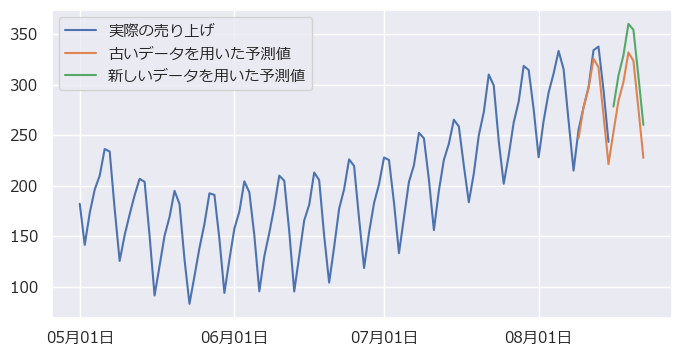

In [14]:
# 古いデータを使ったモデルで2週間先まで予測
old_forecast = mod_sample.forecast(14)

# 新しいデータを使ったモデルで1週間先まで予測
new_forecast = mod_newdata.forecast(7)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(train_sample_2, label='実際の売り上げ')
ax.plot(old_forecast, label='古いデータを用いた予測値')
ax.plot(new_forecast, label='新しいデータを用いた予測値')

# 凡例
ax.legend()

# 軸の指定
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m月%d日'))

# plt.savefig('../図/図/7-1-1-データを追加することで変化する予測結果.svg')

### appendメソッドを用いたデータの追加

In [15]:
# 追加データ
train_update = train_sample_2.loc['2000-08-09':'2000-08-15']

# データを追加したモデル
mod_update = mod_sample.append(train_update)

In [16]:
# フィルター化推定量が一致する
all(mod_newdata.level["filtered"] == mod_update.level["filtered"])

True

In [17]:
# 予測値も一致する
all(new_forecast == mod_update.forecast(7))

True

### 複数の予測系列への分析事例

#### データの読み込み

In [18]:
# データの読み込み
large_data_1 = pd.read_csv('7-1-3-large-train-1.csv', 
                      index_col='date', 
                      parse_dates=True, 
                      dtype='float')

# 日データであることの指定
large_data_1.index.freq = 'D'

# 最初と最後の日付
print(large_data_1.index[[0, -1]])

DatetimeIndex(['2000-05-01', '2000-08-08'], dtype='datetime64[ns]', name='date', freq=None)


In [19]:
large_data_1.shape

(100, 50)

In [20]:
large_data_1.columns

Index(['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9',
       'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 'y_18',
       'y_19', 'y_20', 'y_21', 'y_22', 'y_23', 'y_24', 'y_25', 'y_26', 'y_27',
       'y_28', 'y_29', 'y_30', 'y_31', 'y_32', 'y_33', 'y_34', 'y_35', 'y_36',
       'y_37', 'y_38', 'y_39', 'y_40', 'y_41', 'y_42', 'y_43', 'y_44', 'y_45',
       'y_46', 'y_47', 'y_48', 'y_49'],
      dtype='object')

#### パラメータの推定と予測

In [21]:
%%time
for i in range(0, large_data_1.shape[1]):    
    # 季節変動ありのローカル線形トレンドモデル
    mod_loop = tsa.UnobservedComponents(
        large_data_1.iloc[:, i],        # 対象データ
        level='local linear trend',     # ローカル線形トレンド
        seasonal=7                      # 周期
    ).fit()

    # パラメータの保存
    if (i == 0):
        params = mod_loop.params
        
         # パラメータを見分けるための名前の設定
        params.name = large_data_1.columns[i]
    else:
        param_temp = mod_loop.params
        
         # パラメータを見分けるための名前の設定
        param_temp.name = large_data_1.columns[i]
        
        # 推定されたパラメータを1つのDataFrameにまとめる
        params = pd.concat([params,param_temp], axis=1)

    # 予測
    if (i == 0):
        forecasts_1 = mod_loop.forecast(14)
        
         # パラメータを見分けるための名前の設定
        forecasts_1.name = large_data_1.columns[i]
    else:
        fore_temp = mod_loop.forecast(14)
        
         # パラメータを見分けるための名前の設定
        fore_temp.name = large_data_1.columns[i]
        
        # 推定されたパラメータを1つのDataFrameにまとめる
        forecasts_1 = pd.concat([forecasts_1, fore_temp], axis=1)


CPU times: total: 594 ms
Wall time: 2.85 s


In [22]:
# 参考：予測結果
forecasts_1

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49
2000-08-09,234.527755,271.580318,338.468888,126.466336,226.069109,127.079978,229.368512,583.443863,330.158721,217.297555,...,487.641718,250.702730,226.174660,623.151330,260.272069,463.528931,568.856548,274.810738,239.526377,469.031701
2000-08-10,128.682613,258.806619,264.112037,110.130186,299.052616,124.478887,199.685791,657.182597,345.374918,269.500389,...,605.008828,210.865084,298.815139,643.209069,366.308615,333.822651,530.418224,183.049942,153.814427,500.936822
2000-08-11,203.142632,271.366055,182.076985,136.001478,271.650303,99.473579,234.576168,631.205762,315.251311,203.915747,...,572.636325,253.004611,264.862444,577.591150,306.356971,457.576418,594.417113,261.017272,201.605767,609.979862
2000-08-12,191.630981,222.830145,299.465197,189.152251,184.729904,98.548676,233.939654,649.720158,271.570035,195.675532,...,530.858306,281.727898,226.225599,686.265180,267.284961,445.141472,557.256792,250.196978,147.898617,590.058962
2000-08-13,192.455529,274.412981,313.583121,134.302317,181.999919,118.905300,191.781073,715.572996,320.149912,279.613109,...,528.744911,284.279315,241.113540,522.417827,159.194152,359.559991,680.265153,299.732632,142.111191,522.995836
2000-08-14,283.011484,280.093720,282.120079,148.128832,225.168480,186.072404,227.382693,679.584427,330.960703,160.026425,...,535.539154,183.578763,296.796635,578.063669,278.545403,481.476838,601.367887,206.104340,136.977021,594.878748
2000-08-15,208.481181,367.949666,264.042215,100.791460,262.305656,106.047602,245.421022,638.878396,330.575884,140.580012,...,642.885306,221.874374,280.191642,636.345155,253.778978,498.289193,620.009832,234.222651,163.910399,570.982414
2000-08-16,178.080488,290.421926,271.670424,107.257795,230.878856,117.202377,247.789533,643.322259,352.734605,202.262168,...,521.477756,247.733622,258.224074,659.177257,216.432064,495.916265,622.943182,267.942877,233.983211,489.677262
2000-08-17,72.235345,277.648226,197.313573,90.921645,303.862364,114.601286,218.106813,717.060993,367.950802,254.465001,...,638.844867,207.895975,330.864553,679.234996,322.468611,366.209985,584.504858,176.182081,148.271261,521.582383
2000-08-18,146.695364,290.207663,115.278521,116.792938,276.460051,89.595978,252.997190,691.084158,337.827195,188.880360,...,606.472364,250.035502,296.911858,613.617078,262.516966,489.963751,648.503748,254.149411,196.062601,630.625423


#### 新しいデータを用いたフィルタリングと予測

In [23]:
# データの読み込み
large_data_2 = pd.read_csv('7-1-4-large-train-2.csv', 
                      index_col='date', 
                      parse_dates=True, 
                      dtype='float')

# 日データであることの指定
large_data_2.index.freq = 'D'

# 最初と最後の日付
print(large_data_2.index[[0, -1]])

DatetimeIndex(['2000-05-01', '2000-08-15'], dtype='datetime64[ns]', name='date', freq=None)


In [24]:
%%time
for i in range(0, large_data_2.shape[1]):    
    # 季節変動ありのローカル線形トレンドモデル
    mod_loop = tsa.UnobservedComponents(
        large_data_2.iloc[:, i],        # 対象データ
        level='local linear trend',     # ローカル線形トレンド
        seasonal=7                      # 周期
    )
    
    # パラメータを指定してフィルタリング
    mod_loop = mod_loop.filter(params = params[large_data_2.columns[i]])

    # 予測
    if (i == 0):
        forecasts_2 = mod_loop.forecast(14)
        
         # パラメータを見分けるための名前の設定
        forecasts_2.name = large_data_2.columns[i]
    else:
        fore_temp = mod_loop.forecast(14)
        
         # パラメータを見分けるための名前の設定
        fore_temp.name = large_data_2.columns[i]
        
        # 推定されたパラメータを1つのDataFrameにまとめる
        forecasts_2 = pd.concat([forecasts_2, fore_temp], axis=1)


CPU times: total: 78.1 ms
Wall time: 187 ms


In [25]:
# 参考：予測結果
forecasts_2

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49
2000-08-16,210.933087,313.738609,256.725444,113.011191,244.658768,102.100221,256.160673,619.325490,340.776921,226.027233,...,517.963863,259.472633,247.169072,621.785045,215.931720,489.518620,623.532291,221.551340,224.110069,498.161880
2000-08-17,106.124819,302.771197,179.078386,95.950884,316.866757,99.641849,225.785742,691.312769,354.739291,281.068257,...,633.959420,219.488821,318.153343,638.416113,321.749988,357.672334,585.021686,130.196927,140.037687,530.474078
2000-08-18,181.268427,317.760945,97.366901,122.749576,289.514014,74.250477,261.612966,663.935548,323.156926,216.237388,...,601.289586,263.332504,282.587039,571.667828,263.265033,482.227916,647.077635,206.535103,185.789703,641.085418
2000-08-19,172.058322,271.174603,214.328592,175.569471,203.233454,72.735281,260.761589,679.651233,279.834081,209.012570,...,559.307889,290.711545,245.994957,678.709475,223.096202,468.633969,610.010622,194.999869,131.632875,622.621711
2000-08-20,176.279021,325.011991,223.582270,121.525888,201.198270,92.427380,218.420948,745.280399,327.525516,293.642739,...,555.661234,295.704433,258.025088,514.290013,114.562058,384.647465,732.922591,243.023571,125.596478,554.698062
2000-08-21,266.817585,332.391861,192.504179,135.088138,243.321354,159.747317,254.521938,705.910975,336.160789,175.587622,...,563.001198,195.035354,311.190814,564.541478,234.043845,505.136139,652.890685,148.967121,122.128505,627.415089
2000-08-22,193.797385,422.502660,173.187643,87.361542,280.977793,79.865971,272.500473,664.203766,337.006147,156.247956,...,668.990339,233.964522,296.388330,623.429965,208.214473,521.348670,670.447824,176.518133,149.219962,605.779606
2000-08-23,166.755871,347.369491,179.288531,94.372733,251.762773,91.197258,276.661146,665.529256,358.783068,219.605507,...,548.417233,259.650712,273.378169,643.168945,170.911363,519.124147,674.747756,207.873607,217.948913,523.353059
2000-08-24,61.947603,336.402079,101.641473,77.312425,323.970761,88.738886,246.286215,737.516536,372.745438,274.646531,...,664.412790,219.666900,344.362440,659.800013,276.729631,387.277861,636.237151,116.519194,133.876531,555.665256
2000-08-25,137.091211,351.391827,19.929987,104.111118,296.618018,63.347514,282.113439,710.139314,341.163074,209.815662,...,631.742957,263.510583,308.796136,593.051727,218.244676,511.833442,698.293100,192.857370,179.628547,666.276597


#### 予測結果の確認

In [26]:
# 予測結果を可視化するための関数
def plot_result(target_data_name):
    # グラフサイズの指定
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # 折れ線グラフを描く
    ax.plot(large_data_2.loc['2000-07-15':][target_data_name], 
            label='実際の売り上げ')
    ax.plot(forecasts_1[target_data_name], 
            label='古いデータを用いた予測値')
    ax.plot(forecasts_2[target_data_name], 
            label='新しいデータを用いた予測値')

    # 凡例
    ax.legend()
    
    # 軸の指定(週ごと)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    
    # 軸ラベルのフォーマット
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m月%d日'))

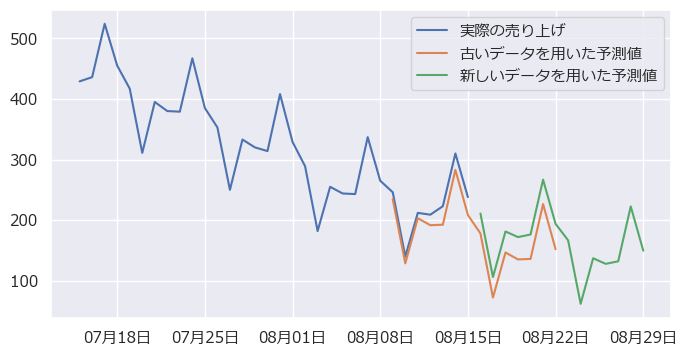

In [27]:
# 予測結果の可視化
plot_result('y_0')